In [1]:
# Imports

import torch
import torch.nn.functional as func
from torch.autograd import Variable
from torchvision import transforms
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt, patches as mpatches, cm
from IPython import display

import big_decoder
from offloading_dataloader import Dataloader, plot_example

class_autoencoder_path = '../networks/big_decoder.pth'

In [2]:
# Helper functions
def to_image(img):
    img = 0.5 * (img + 1)
    img = img.clamp(0, 1)
    img = (img.view(img.shape[-2], img.shape[-1])).detach().numpy()
    return img

def normalize_image(img):
    img = img / 255
    img = transforms.Normalize((0.5, ), (0.5, ))(img)
    return img

def show_img(img, lbl):
    img = (img.view(img.shape[-2], img.shape[-1])).detach().numpy()
    plt.imshow(img, cmap=cm.gray_r)
    plt.title(lbl)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def transform_image(image, action):
    def transformation_matrix(scale=1, rotation=0):
        # scale
        T_scale = torch.Tensor([[scale+1e-8, 0, 0],
                                [0, scale+1e-8, 0],
                                [0, 0, 1]])
        # rotation
        T_rot = torch.Tensor([[torch.cos(rotation), -torch.sin(rotation), 0],
                              [torch.sin(rotation), torch.cos(rotation), 0],
                              [0, 0, 1]])

        # combine matrices
        T = T_rot @ T_scale
        T_inv = torch.linalg.inv(T)
        return T_inv[0:2, :]

    if not image.size() == torch.zeros(size=[1, 1, 56, 56]).size():
        image = torch.reshape(image, [1, 1, 56, 56])

    matrix = torch.reshape(transformation_matrix(action[0], action[1]), [1,2,3])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        grid = func.affine_grid(matrix, image.size())
        trns_image = func.grid_sample(image, grid, padding_mode='border')

    return trns_image

Active MNIST Dataloader initialized on <class 'torch.FloatTensor'>
batch_size = 1024, iterations = 64
     Sampling indices
     Creating random transformation values
     Padding images
     Transforming images


F:\OneDrive\Documents\University\Bachelor Thesis\active_mnist_thesis\offloading_dataloader.py:81: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:189.)
  self.images = torch.Tensor(np.reshape(images, [images.shape[0], 1, images.shape[1], images.shape[2]]))


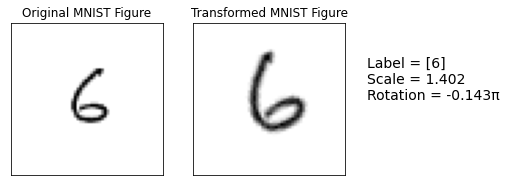

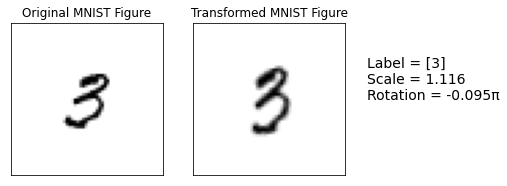

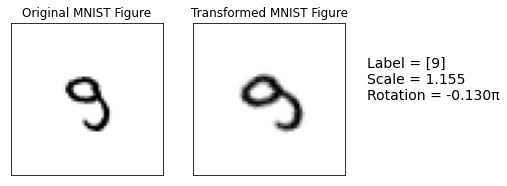

In [3]:
# Initialize and demonstrate dataloader
dtype = torch.FloatTensor

dataloader = Dataloader(image_path='../data/train-images.idx3-ubyte',
                        label_path='../data/train-labels.idx1-ubyte',
                        dtype=dtype)

or_img, trns_img, lbl, pose = dataloader.sample(100)
plot_example(or_img, trns_img, lbl, pose, number_examples=3)

In [4]:
# Load network
decoder = big_decoder.Decoder(dtype=dtype)
decoder.load_state_dict(torch.load(class_autoencoder_path))
decoder.eval()

print('Loaded networks on device', dtype)

Loaded networks on device <class 'torch.FloatTensor'>


In [5]:
# Model Implementation
class CogOffloadingModel:
    def __init__(self, net, iterations=100):
        self.iterations = iterations
        self.step = 0.1

        self.plot_iter = 0

        self.sigma_x = 10
        self.sigma_z = 10

        self.len_h = 32

        self.c = torch.ones(size=[1, 10])/10
        self.v = torch.ones(size=[1, 10])/10
        self.z = torch.Tensor([[1, 0]])
        self.h = torch.zeros(size=[1, self.len_h])
        self.obs_x = torch.zeros(size=[1, 1, 56, 56])
        self.pred_x = torch.zeros(size=[1, 1, 56,56])
        self.prior_x = torch.zeros(size=[1, 1, 56,56])

        self.h_record = None
        self.z_record = None

        net.eval()
        self.decoder = net.decoder
        self.classifier = net.classifier

        # plotting
        self.fig = plt.figure(constrained_layout=True, figsize=(12, 9))
        gs = self.fig.add_gridspec(3, 4)

        self.axs_obs_x = self.fig.add_subplot(gs[0, 0], adjustable='box')
        self.axs_prior_x = self.fig.add_subplot(gs[0, 3], adjustable='box')
        self.axs_pred_x = self.fig.add_subplot(gs[0:2, 1:3], adjustable='box')
        self.axs_c = self.fig.add_subplot(gs[1, 0], adjustable='box')
        self.axs_z = self.fig.add_subplot(gs[1, 3], adjustable='box')
        self.axs_h_record = self.fig.add_subplot(gs[2, 0:2], adjustable='box')
        self.axs_z_record = self.fig.add_subplot(gs[2, 2:4], adjustable='box')

        self.fig.suptitle('Cognitive Offloading Model', fontsize=20)

    def update_plot(self):
        self.axs_obs_x.clear()
        self.axs_obs_x.imshow(to_image(self.obs_x), cmap=cm.gray_r)
        self.axs_obs_x.set_xticks([])
        self.axs_obs_x.set_yticks([])
        self.axs_obs_x.set_title('Observed Image')

        self.axs_prior_x.clear()
        self.axs_prior_x.imshow(to_image(self.prior_x), cmap=cm.gray_r)
        self.axs_prior_x.set_xticks([])
        self.axs_prior_x.set_yticks([])
        self.axs_prior_x.set_title('Prior')

        self.axs_pred_x.clear()
        self.axs_pred_x.imshow(to_image(self.pred_x), cmap=cm.gray_r)
        self.axs_pred_x.set_xticks([])
        self.axs_pred_x.set_yticks([])
        self.axs_pred_x.set_title('Image predicted by latent states')

        self.axs_c.clear()
        self.axs_c.bar(range(10), torch.squeeze(self.c).detach().numpy(), color='red', zorder=1)
        self.axs_c.set_xticks(range(10))
        self.axs_c.set_ylabel('Probability')
        self.axs_c.set_ylim(0, 1)
        self.axs_c.set_title('Belief over digit class')

        self.axs_z.clear()
        self.axs_z.vlines(range(2), -4, 4, colors='grey', alpha=0.7, zorder=0)
        self.axs_z.hlines(0, -1, 2, colors='grey', alpha=0.7, zorder=0)
        self.axs_z.scatter(range(2), torch.squeeze(self.z), c='green', zorder=1)
        self.axs_z.set_ylim(-3.5, 3.5)
        self.axs_z.set_xlim(-0.5, 1.5)
        self.axs_z.set_xticks(range(2))
        self.axs_z.set_xticklabels(['scale', 'rotation'])

        self.axs_h_record.clear()
        self.axs_h_record.plot(self.h_record)
        self.axs_h_record.set_title('Latent space encoding digit class')
        self.axs_h_record.set_xlabel('Iterations')

        self.axs_z_record.clear()
        self.axs_z_record.plot(self.z_record, color='green')
        self.axs_z_record.set_title('Transition of pose')
        self.axs_z_record.set_xlabel('Iterations')

        display.display(plt.gcf())
        plt.savefig(f'animation/plt{self.plot_iter}.png', transparent=False)
        self.plot_iter += 1
        display.clear_output(wait=True)

    def set_obs_image(self, img):
        self.obs_x = normalize_image(img)

    def P_x_cz(self):
        # TODO: make function
        return 1

    def grad_obs(self, states):
        var_states = Variable(states, requires_grad=True)
        var_states.grad = torch.zeros(var_states.size())

        self.pred_x = self.decoder(var_states)

        error = (1/self.sigma_x) * (self.obs_x - self.pred_x)
        self.pred_x.backward(torch.ones(self.pred_x.shape)*error, retain_graph=True)

        return var_states.grad


    def grad_prior(self, states):
        states = torch.concat((states[:,:self.len_h], torch.Tensor([[1, 0]])), dim=1)
        var_states = Variable(states, requires_grad=True)
        var_states.grad = torch.zeros(var_states.size())

        self.prior_x = self.decoder(var_states)

        error = (1/self.sigma_x) * (self.prior_x - self.pred_x)
        self.pred_x.backward(torch.ones(self.pred_x.shape)*error, retain_graph=True)

        return var_states.grad

    def infer_int_state(self, with_prior=True):
        self.h = torch.randn(size=self.h.size())

        self.h_record = torch.squeeze(self.h)
        self.z_record = torch.squeeze(self.z)

        for i in range(self.iterations):
            states = torch.concat((self.h, self.z), dim=1)
            states_dot = self.grad_obs(states)
            #print(states_dot)
            if with_prior:
                states_dot[:,-2:] += self.grad_prior(states)[:,-2:] * 0.1 # only affect z

            z_dot = states_dot[:,-2:]
            self.z = torch.add(self.z, z_dot, alpha=self.step)

            h_dot = states_dot[:,:self.len_h]
            self.h = torch.add(self.h, h_dot, alpha=self.step)

            self.c = self.classifier(self.h)

            # visualisation/debugging
            self.h_record = np.vstack([self.h_record, torch.squeeze(self.h)])
            self.z_record = np.vstack([self.z_record, torch.squeeze(self.z)])
            if i % 10 == 0:
                self.update_plot()
                pass


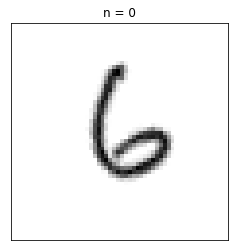

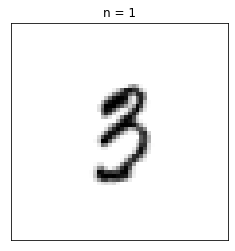

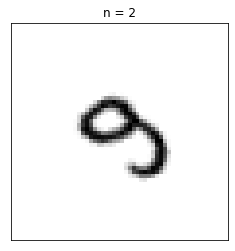

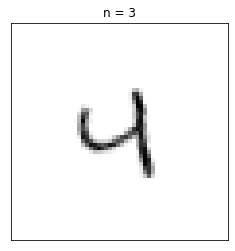

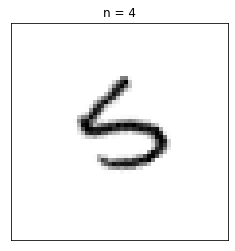

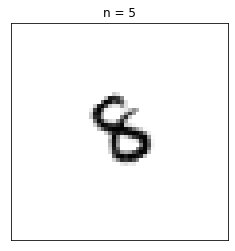

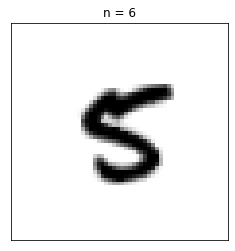

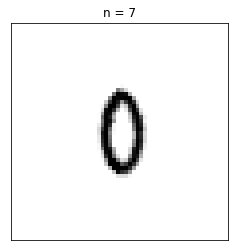

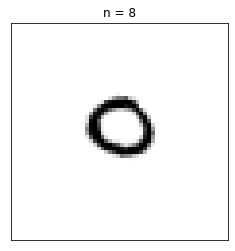

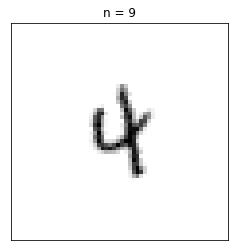

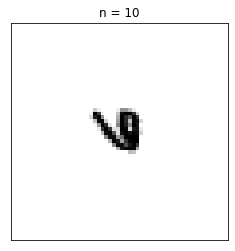

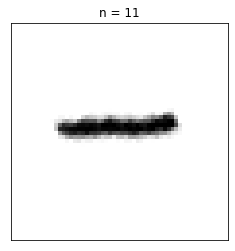

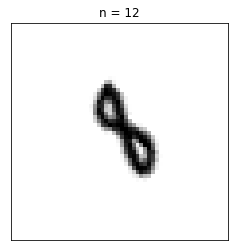

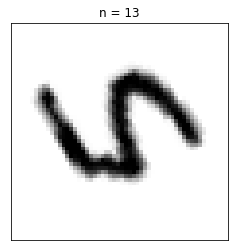

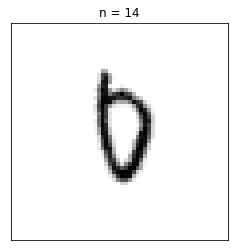

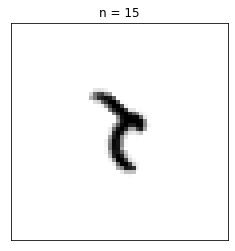

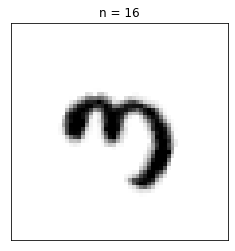

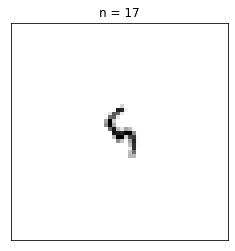

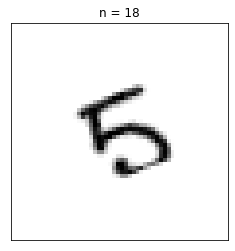

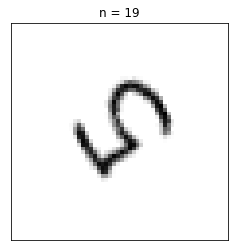

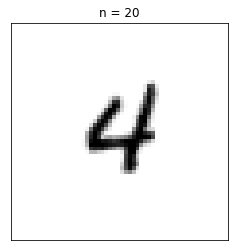

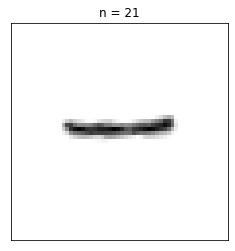

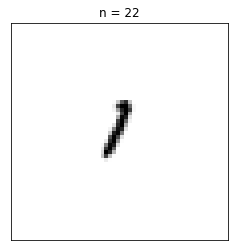

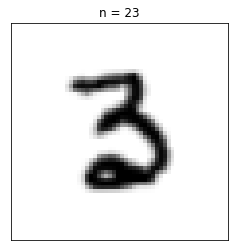

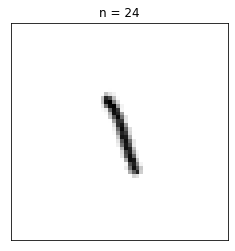

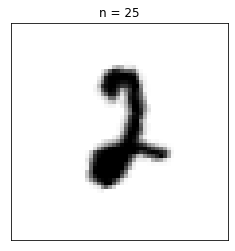

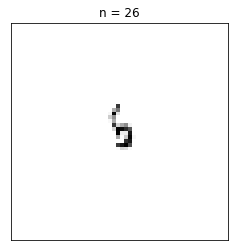

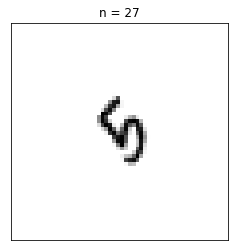

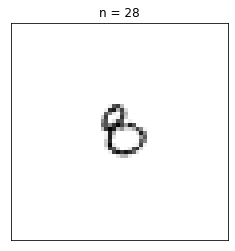

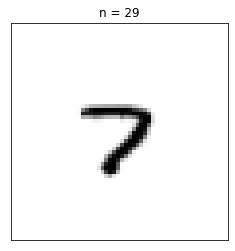

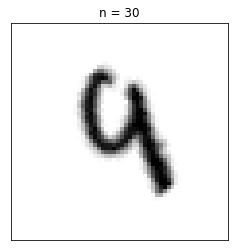

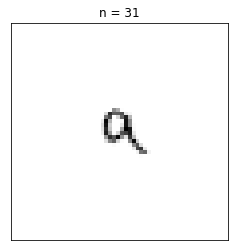

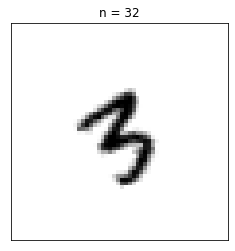

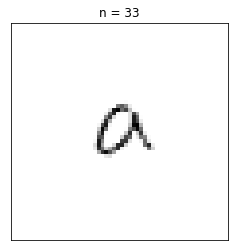

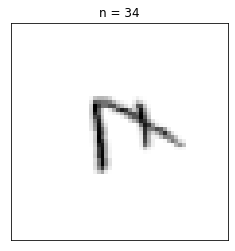

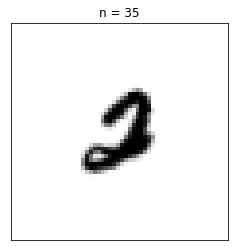

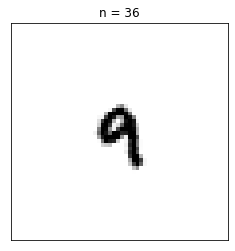

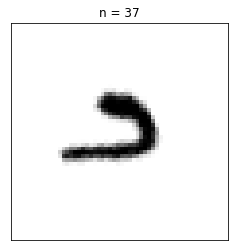

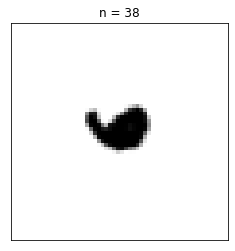

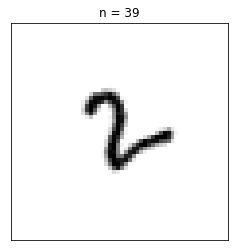

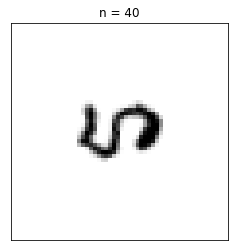

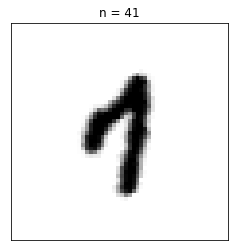

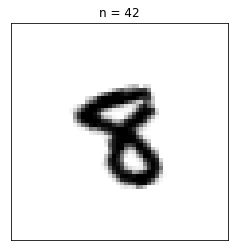

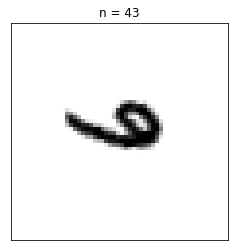

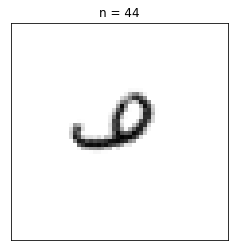

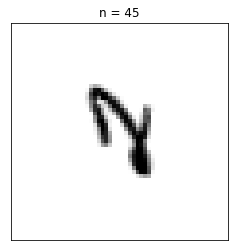

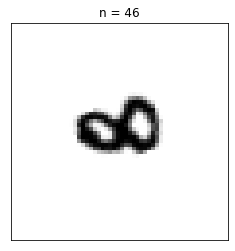

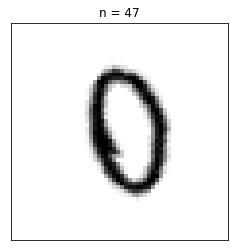

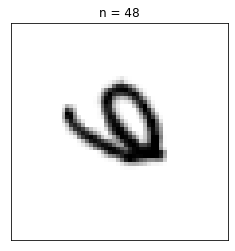

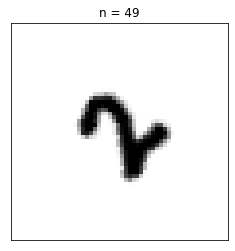

In [12]:
for i in range(50):
    show_img(trns_img[i], lbl=f'n = {i}')

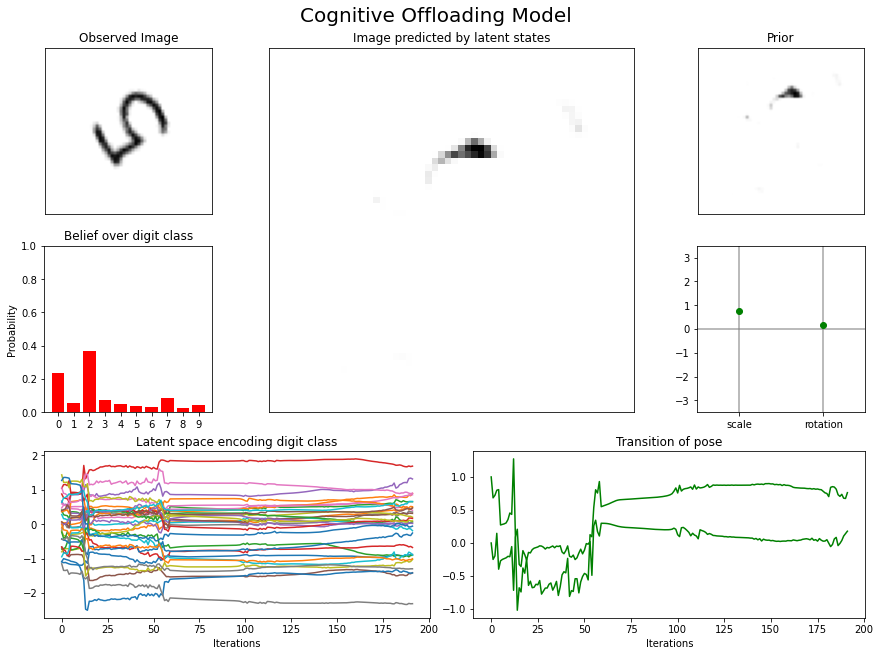

In [15]:
n = 19

model = CogOffloadingModel(decoder, iterations=200)
model.set_obs_image(trns_img[n])

model.infer_int_state(with_prior=True)